In [180]:
!pip install yfinance

In [181]:
!pip install fbprophet

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import datetime as dt
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from google.colab import files


# Objetivos

1.   Avaliar a acurácia da arquitetura de redes neurais recorrentes LSTM sob variações de parâmetros para a predição do preço de fechamento de quatro ações de empresas de setores distintos do mercado brasileiro (bancário, elétrico, bens de capital e varejista) nos últimos três meses de 2020, utilizando a média dos valores de raiz do erro quadrático médio (RMSE) como métricas para validação, em comparação com a acurácia de uma rede neural artificial.
2.   Utilizar a arquitetura de redes neurais recorrentes LSTM para estimar/predizer/prever o preço de ações.

#### Carregar dados


In [183]:
stocks = ['BBDC4.SA', 'CMIG4.SA', 'SHUL4.SA', 'MGLU3.SA']

# Carrega os dados das ações escolhidas no período 01/01/2020 a 31/12/2020
bbdc4_data = pd.DataFrame(yf.download(stocks[0], start="2016-01-01", end="2020-12-31"))
cmig4_data = pd.DataFrame(yf.download(stocks[1], start="2016-01-01", end="2020-12-31"))
shul4_data = pd.DataFrame(yf.download(stocks[2], start="2016-01-01", end="2020-12-31"))
mglu3_data = pd.DataFrame(yf.download(stocks[3], start="2016-01-01", end="2020-12-31"))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


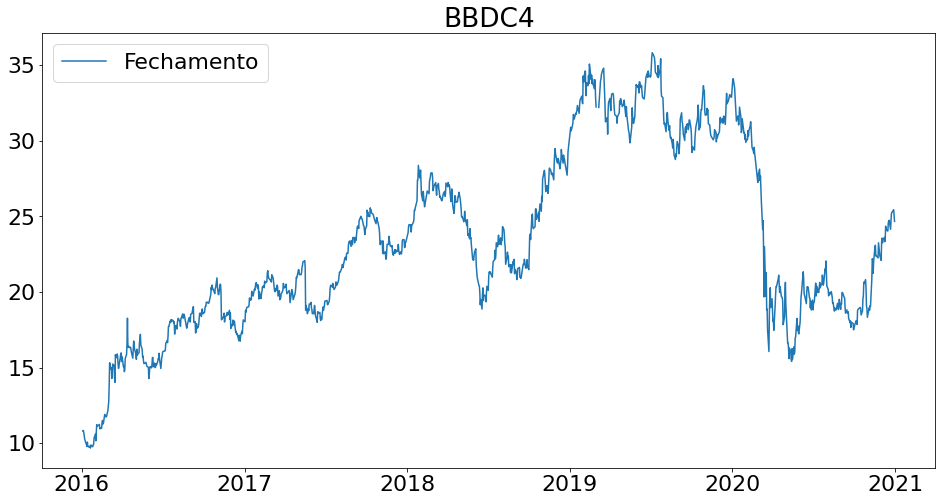

In [184]:
plt.figure(figsize=(16, 8))
plt.title('BBDC4')
plt.plot(bbdc4_data['Close'], label = 'Fechamento')
plt.legend(loc='upper left')

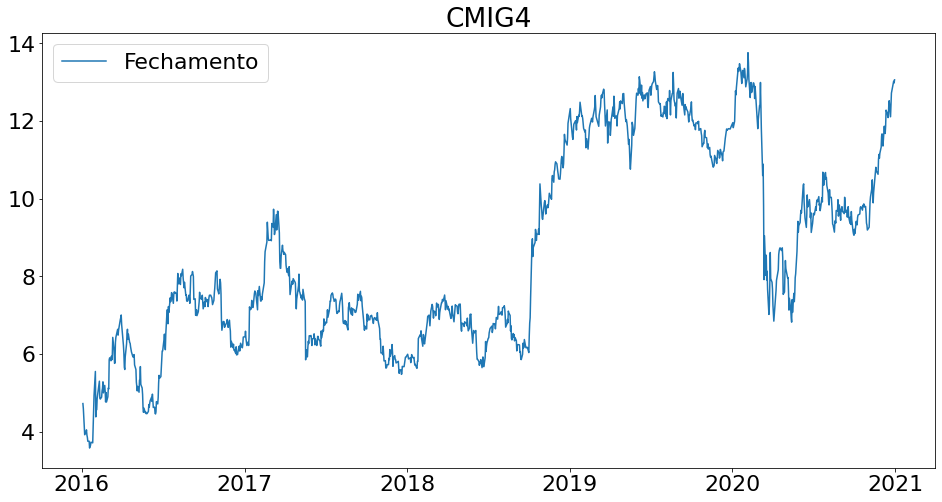

In [185]:
plt.figure(figsize=(16, 8))
plt.title('CMIG4')
plt.plot(cmig4_data['Close'], label = 'Fechamento')
plt.legend(loc='upper left')

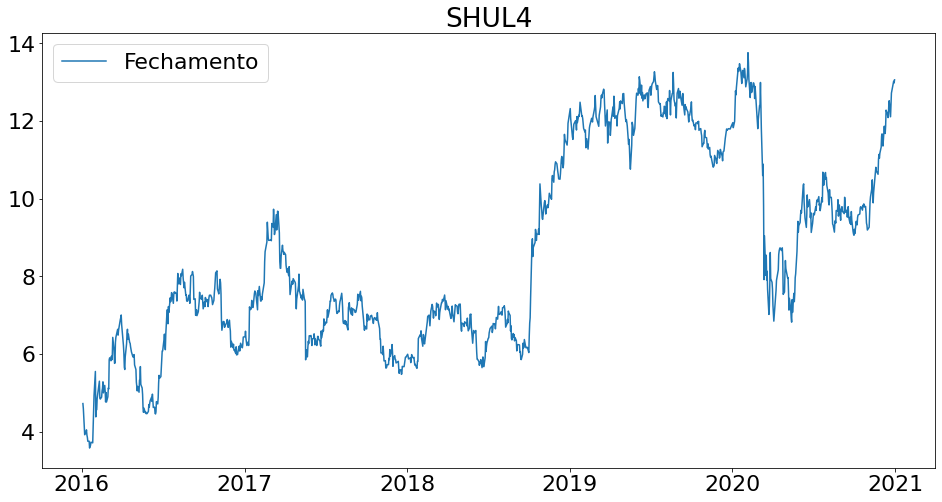

In [186]:
plt.figure(figsize=(16, 8))
plt.title('SHUL4')
plt.plot(cmig4_data['Close'], label = 'Fechamento')
plt.legend(loc='upper left')

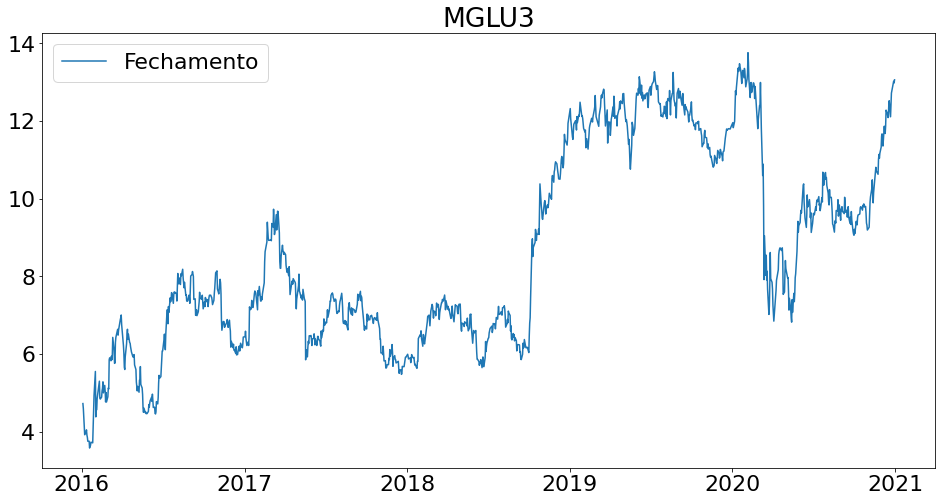

In [187]:
plt.figure(figsize=(16, 8))
plt.title('MGLU3')
plt.plot(cmig4_data['Close'], label = 'Fechamento')
plt.legend(loc='upper left')

## Pré-processamento dos dados

### Transformação da série temporal em aprendizado supervisionado

#### Transformação realizada para utilizar a data dos registros como índice e o preço de fechamento como saída/alvo

In [188]:
# Séries temporais transformadas em aprendizado supervisionado para a RNN LSTM e o Prophet
def timeseries_to_supervised_learning(df):
  df = df.reset_index()
  df = df.sort_index(ascending=True, axis=0)

  data_for_lstm = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
  data_for_prophet = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
  for i in range(0, len(df)):
    data_for_lstm['Date'][i] = df['Date'][i]
    data_for_lstm['Close'][i] = df['Close'][i]
    data_for_prophet['Date'][i] = df['Date'][i]
    data_for_prophet['Close'][i] = df['Close'][i]

  return data_for_lstm, data_for_prophet

In [189]:
# Dados para uso na RNN LSTM
def data_for_lstm(df):  
  df.index = df['Date']
  df.drop('Date', axis=1, inplace=True)
  return df

# Dados para uso no Prophet
## Necessário nomear o índice ('Date') como 'ds', que representa a data,
## e a saída/alvo ('Close') como 'y', que representa o preço de fechamento 

def data_for_prophet(df):
  df[['ds', 'y']] = df[['Date', 'Close']]
  df.drop('Date', axis=1, inplace=True)
  df.drop('Close', axis=1, inplace=True)
  return df

#### Geração dos data frames para as ações a serem analisadas

In [190]:
# Dados para ação BBDC4
bbdc4_data_for_lstm, bbdc4_data_for_prophet = timeseries_to_supervised_learning(bbdc4_data)

bbdc4_data_for_lstm = data_for_lstm(bbdc4_data_for_lstm)
bbdc4_data_for_prophet = data_for_prophet(bbdc4_data_for_prophet)

# Dados para ação CMIG4
cmig4_data_for_lstm, cmig4_data_for_prophet = timeseries_to_supervised_learning(cmig4_data)

cmig4_data_for_lstm = data_for_lstm(cmig4_data_for_lstm)
cmig4_data_for_prophet = data_for_prophet(cmig4_data_for_prophet)

# Dados para ação WEGE3
shul4_data_for_lstm, shul4_data_for_prophet = timeseries_to_supervised_learning(shul4_data)

shul4_data_for_lstm = data_for_lstm(shul4_data_for_lstm)
shul4_data_for_prophet = data_for_prophet(shul4_data_for_prophet)

# Dados para ação MGLU3
mglu3_data_for_lstm, mglu3_data_for_prophet = timeseries_to_supervised_learning(mglu3_data)

mglu3_data_for_lstm = data_for_lstm(mglu3_data_for_lstm)
mglu3_data_for_prophet = data_for_prophet(mglu3_data_for_prophet)

#### Remoção de registros inválidos 

In [191]:
bbdc4_data_for_lstm = bbdc4_data_for_lstm.dropna()
bbdc4_data_for_prophet = bbdc4_data_for_prophet.dropna()

cmig4_data_for_lstm = cmig4_data_for_lstm.dropna()
cmig4_data_for_prophet = cmig4_data_for_prophet.dropna()

shul4_data_for_lstm = shul4_data_for_lstm.dropna()
shul4_data_for_prophet = shul4_data_for_prophet.dropna()

mglu3_data_for_lstm = mglu3_data_for_lstm.dropna()
mglu3_data_for_prophet = mglu3_data_for_prophet.dropna()

### Separação dos dados em conjuntos de treinamento e teste

In [192]:
def train_validation_split(df, lstm=True):
  if lstm:
    dataset = df.values
    train_data = dataset[0:991, :]
    validation_data = dataset[991:, :] 
  else:
    train_data = df[:991]
    validation_data = df[991:]

  return train_data, validation_data

In [193]:
# Conjuntos de treinamento e teste para a RNN LSTM
bbdc4_train_for_lstm, bbdc4_validation_for_lstm = train_validation_split(bbdc4_data_for_lstm)
cmig4_train_for_lstm, cmig4_validation_for_lstm = train_validation_split(cmig4_data_for_lstm)
shul4_train_for_lstm, shul4_validation_for_lstm = train_validation_split(shul4_data_for_lstm)
mglu3_train_for_lstm, mglu3_validation_for_lstm = train_validation_split(mglu3_data_for_lstm)

# Conjuntos de treinamento e teste para Prophet
bbdc4_train_for_prophet, bbdc4_validation_for_prophet = train_validation_split(bbdc4_data_for_prophet, False)
cmig4_train_for_prophet, cmig4_validation_for_prophet = train_validation_split(cmig4_data_for_prophet, False)
shul4_train_for_prophet, shul4_validation_for_prophet = train_validation_split(shul4_data_for_prophet, False)
mglu3_train_for_prophet, mglu3_validation_for_prophet = train_validation_split(mglu3_data_for_prophet, False)

 ### Normalização dos dados para valores entre 0 e 1 para a RNN LSTM
 ##### (Desnecessário realizar o mesmo para o Prophet, uma vez que toda a lógica é realizada na própria funcionalidade)

In [194]:
scaler = MinMaxScaler(feature_range=(0, 1))
bbdc4_scaled_data = scaler.fit_transform(bbdc4_data_for_lstm.values)
cmig4_scaled_data = scaler.fit_transform(cmig4_data_for_lstm.values)
shul4_scaled_data = scaler.fit_transform(shul4_data_for_lstm.values)
mglu3_scaled_data = scaler.fit_transform(mglu3_data_for_lstm.values)


### Ajuste dos conjuntos de treinamento aos parâmetros
##### É criado um conjunto de treinamento que "olha" *X* dias para trás para realizar a previsão do que acontecerá em cada um dos dias seguintes.
##### Para o presente trabalho, foi utilizado um valor de 90 dias, o que equivale, no contexto de dias úteis da B3, a 4 meses (agosto a dezembro de 2020). 

In [195]:
def adjust_train_data_to_params(train_data, scaled_data, base_prediction_days):
  x_train, y_train = [], []
  for j in range(base_prediction_days, len(train_data)):
    x_train.append(scaled_data[j-base_prediction_days:j, 0])
    y_train.append(scaled_data[j, 0])
  
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  return x_train, y_train

In [196]:
base_prediction_days = 90

bbdc4_x_train, bbdc4_y_train = adjust_train_data_to_params(bbdc4_train_for_lstm, bbdc4_scaled_data, base_prediction_days)
cmig4_x_train, cmig4_y_train = adjust_train_data_to_params(cmig4_train_for_lstm, cmig4_scaled_data, base_prediction_days)
shul4_x_train, shul4_y_train = adjust_train_data_to_params(shul4_train_for_lstm, shul4_scaled_data, base_prediction_days)
mglu3_x_train, mglu3_y_train = adjust_train_data_to_params(mglu3_train_for_lstm, mglu3_scaled_data, base_prediction_days)

## Criação do modelo LSTM

1. Criar o modelo LSTM
2. Calcular e comparar a acurácia dos modelos em relação aos parâmetros escolhidos em (1) para cada uma das ações escolhidas



In [197]:
# Configuração da rede
n_batch      = 10
n_epoch      = 20
n_neurons    = 50

def root_mean_squared_error(y_true, y_pred):
  rmse = tf.metrics.RootMeanSquaredError(y_true, y_pred)
  K.get_session().run(tf.local_variables_initializer()) 
  return rmse

bbdc4_prophet_model = Prophet(daily_seasonality=True)
cmig4_prophet_model = Prophet(daily_seasonality=True)
shul4_prophet_model = Prophet(daily_seasonality=True)
mglu3_prophet_model = Prophet(daily_seasonality=True)

In [198]:
bbdc4_lstm_model = Sequential()
bbdc4_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(bbdc4_x_train.shape[1],1), recurrent_dropout=0.2))
bbdc4_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, recurrent_dropout=0.2))
bbdc4_lstm_model.add(LSTM(units=n_neurons, recurrent_dropout=0.2))
bbdc4_lstm_model.add(Dense(1))

cmig4_lstm_model = Sequential()
cmig4_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(cmig4_x_train.shape[1],1), recurrent_dropout=0.2))
cmig4_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, recurrent_dropout=0.2))
cmig4_lstm_model.add(LSTM(units=n_neurons, recurrent_dropout=0.2))
cmig4_lstm_model.add(Dense(1))

shul4_lstm_model = Sequential()
shul4_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(shul4_x_train.shape[1],1), recurrent_dropout=0.2))
shul4_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, recurrent_dropout=0.2))
shul4_lstm_model.add(LSTM(units=n_neurons, recurrent_dropout=0.2))
shul4_lstm_model.add(Dense(1))

mglu3_lstm_model = Sequential()
mglu3_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(mglu3_x_train.shape[1],1), recurrent_dropout=0.2))
mglu3_lstm_model.add(LSTM(units=n_neurons, return_sequences=True, recurrent_dropout=0.2))
mglu3_lstm_model.add(LSTM(units=n_neurons, recurrent_dropout=0.2))
mglu3_lstm_model.add(Dense(1))

## Execução do modelo

### Compilação e treinamento do modelo

In [199]:
def compile_fit_model(model, x_train, y_train, n_epochs, n_batch_size):
    model.compile(loss='mse', optimizer='adam', metrics = [tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x_train, y_train, epochs = n_epochs, batch_size = n_batch_size)

In [200]:
# Treinamento via LSTM
bbdc4_history = compile_fit_model(bbdc4_lstm_model, bbdc4_x_train, bbdc4_y_train, n_epoch, n_batch)
cmig4_history = compile_fit_model(cmig4_lstm_model, cmig4_x_train, cmig4_y_train, n_epoch, n_batch)
shul4_history = compile_fit_model(shul4_lstm_model, shul4_x_train, shul4_y_train, n_epoch, n_batch)
mglu3_history = compile_fit_model(mglu3_lstm_model, mglu3_x_train, mglu3_y_train, n_epoch, n_batch)

# Treinamento via Prophet
bbdc4_prophet_history = bbdc4_prophet_model.fit(bbdc4_train_for_prophet)
cmig4_prophet_history = cmig4_prophet_model.fit(cmig4_train_for_prophet)
shul4_prophet_history = shul4_prophet_model.fit(shul4_train_for_prophet)
mglu3_prophet_history = mglu3_prophet_model.fit(mglu3_train_for_prophet)


Epoch 1/20
91/91 [==============================] - 18s 150ms/step - loss: 0.0438 - root_mean_squared_error: 0.2094
Epoch 2/20
91/91 [==============================] - 14s 152ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364
Epoch 3/20
91/91 [==============================] - 14s 151ms/step - loss: 0.0159 - root_mean_squared_error: 0.1260
Epoch 4/20
91/91 [==============================] - 14s 149ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217
Epoch 5/20
91/91 [==============================] - 13s 145ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197
Epoch 6/20
91/91 [==============================] - 13s 142ms/step - loss: 0.0134 - root_mean_squared_error: 0.1160
Epoch 7/20
91/91 [==============================] - 13s 144ms/step - loss: 0.0129 - root_mean_squared_error: 0.1137
Epoch 8/20
91/91 [==============================] - 13s 144ms/step - loss: 0.0129 - root_mean_squared_error: 0.1134
Epoch 9/20
91/91 [==============================] - 14s 151ms/step - los

## Previsão dos últimos 251 preços das ações selecionadas, utilizando como entrada os preços nos últimos 90 registros.
### O valor 251 é equivalente à quantidade de dias úteis do ano de 2020



In [201]:
def create_test_dataset(data, validation_data, base_prediction_days):
  inputs = data[(len(data) - len(validation_data) - base_prediction_days):].values
  inputs = inputs.reshape(-1,1)
  inputs  = scaler.transform(inputs)

  X_test = []
  y_test = []

  for i in range(base_prediction_days,inputs.shape[0]):
    X_test.append(inputs[i-base_prediction_days:i, 0])
    y_test.append(inputs[i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  return X_test

def predict_close_price_with_lstm(model, X_test):
  close_price = model.predict(X_test)
  close_price = scaler.inverse_transform(close_price)
  return close_price[:,0]

def predict_close_price_with_prophet(model, X_test):
  close_price = model.make_future_dataframe(periods=len(X_test))
  close_price = model.predict(close_price)
  close_price = close_price['yhat'][991:]
  return close_price

In [202]:
bbdc4_train = bbdc4_data_for_lstm[:991]
bbdc4_validation = bbdc4_data_for_lstm[991:]

cmig4_train = cmig4_data_for_lstm[:991]
cmig4_validation = cmig4_data_for_lstm[991:]

shul4_train = shul4_data_for_lstm[:991]
shul4_validation = shul4_data_for_lstm[991:]

mglu3_train = mglu3_data_for_lstm[:991]
mglu3_validation = mglu3_data_for_lstm[991:]

In [203]:
bbdc4_X_test = create_test_dataset(bbdc4_data_for_lstm, bbdc4_validation, base_prediction_days)
bbdc4_close_price_with_lstm = predict_close_price_with_lstm(bbdc4_lstm_model, bbdc4_X_test)
bbdc4_close_price_with_prophet = predict_close_price_with_prophet(bbdc4_prophet_model, bbdc4_X_test)

cmig4_X_test = create_test_dataset(cmig4_data_for_lstm, cmig4_validation, base_prediction_days)
cmig4_close_price_with_lstm = predict_close_price_with_lstm(cmig4_lstm_model, cmig4_X_test)
cmig4_close_price_with_prophet = predict_close_price_with_prophet(cmig4_prophet_model, cmig4_X_test)

shul4_X_test = create_test_dataset(shul4_data_for_lstm, shul4_validation, base_prediction_days)
shul4_close_price_with_lstm = predict_close_price_with_lstm(shul4_lstm_model, shul4_X_test)
shul4_close_price_with_prophet = predict_close_price_with_prophet(shul4_prophet_model, shul4_X_test)

mglu3_X_test = create_test_dataset(mglu3_data_for_lstm, mglu3_validation, base_prediction_days)
mglu3_close_price_with_lstm = predict_close_price_with_lstm(mglu3_lstm_model, mglu3_X_test)
mglu3_close_price_with_prophet = predict_close_price_with_prophet(mglu3_prophet_model, mglu3_X_test)

ValueError: ignored

## Cálculo e armazenamento dos valores de acurácia dos modelos


In [ ]:
def calculate_rmse(y_true, y_pred, lstm=True):
  if lstm:
    rmse = np.sqrt(np.mean(np.power((y_true['Close'] - y_pred),2)))
  else:
    rmse = np.sqrt(np.mean(np.power((y_true['y'] - y_pred),2)))
  
  return rmse

In [ ]:
rmse_df = pd.DataFrame()

### RMSE - BBDC4

In [ ]:
bbdc4_rmse_for_lstm = calculate_rmse(bbdc4_validation, bbdc4_close_price_with_lstm)
print('BBDC4 - LSTM (RMSE): {: 2.6f}'.format(bbdc4_rmse_for_lstm))
bbdc4_rmse_for_prophet = calculate_rmse(bbdc4_validation_for_prophet, bbdc4_close_price_with_prophet, False)
print('BBDC4 - LSTM (RMSE) {: 2.6f}: '.format(bbdc4_rmse_for_prophet))

In [ ]:
rmse_df = rmse_df.append({'Ação' : 'BBDC4', 'LSTM (RMSE)' : bbdc4_rmse_for_lstm, 'Prophet (RMSE)' : bbdc4_rmse_for_prophet}, ignore_index=True)

### RMSE - CMIG4

In [ ]:
cmig4_rmse_for_lstm = calculate_rmse(cmig4_validation, cmig4_close_price_with_lstm)
print('CMIG4 - LSTM (RMSE): {: 2.6f}'.format(cmig4_rmse_for_lstm))
cmig4_rmse_for_prophet = calculate_rmse(cmig4_validation_for_prophet, cmig4_close_price_with_prophet, False)
print('CMIG4 - LSTM (RMSE): {: 2.6f}'.format(cmig4_rmse_for_prophet))

In [ ]:
rmse_df = rmse_df.append({'Ação' : 'CMIG4', 'LSTM (RMSE)' : cmig4_rmse_for_lstm, 'Prophet (RMSE)' : cmig4_rmse_for_prophet}, ignore_index=True)

### RMSE - SHUL4

In [ ]:
shul4_rmse_for_lstm = calculate_rmse(shul4_validation, shul4_close_price_with_lstm)
print('SHUL4 - LSTM (RMSE): {: 2.6f}'.format(shul4_rmse_for_lstm))
shul4_rmse_for_prophet = calculate_rmse(shul4_validation_for_prophet, shul4_close_price_with_prophet, False)
print('SHUL4 - LSTM (RMSE): {: 2.6f}'.format(shul4_rmse_for_prophet))

In [ ]:
rmse_df = rmse_df.append({'Ação' : 'SHUL4', 'LSTM (RMSE)' : shul4_rmse_for_lstm, 'Prophet (RMSE)' : shul4_rmse_for_prophet}, ignore_index=True)

### RMSE - MGLU3

In [ ]:
mglu3_rmse_for_lstm = calculate_rmse(mglu3_validation, mglu3_close_price_with_lstm)
print('MGLU3 - LSTM (RMSE): {: 2.2f}'.format(mglu3_rmse_for_lstm))
mglu3_rmse_for_prophet = calculate_rmse(mglu3_validation_for_prophet, mglu3_close_price_with_prophet, False)
print('MGLU3 - LSTM (RMSE): {: 2.2f}'.format(mglu3_rmse_for_prophet))

In [ ]:
rmse_df = rmse_df.append({'Ação' : 'MGLU3', 'LSTM (RMSE)' : mglu3_rmse_for_lstm, 'Prophet (RMSE)' : mglu3_rmse_for_prophet}, ignore_index=True)

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

In [ ]:
rmse_df.index = rmse_df['Ação']
rmse_df.drop('Ação', axis=1, inplace=True)

In [ ]:
rmse_df.to_excel("rmse_lstm_prophet.xlsx", float_format='%.2f')
files.download("rmse_lstm_prophet.xlsx") 

## Visualização da previsão

In [ ]:
'''plt.rcParams.update({'font.size': 22})

plt.figure(figsize=(16, 8))
train = bbdc4_data_for_lstm[:991]#[:173]
t_2020 = train['2019']
bbdc4_validation = bbdc4_data_for_lstm[991:]#[173:]
bbdc4_validation['Predictions'] = preco_fechamento
bbdc4_validation['Predictions_2'] = preco_fechamento_2
bbdc4_validation['Prophet'] = preco_fechamento_3.values
#bbdc4_validation['Diff_Close-Model'] = abs(bbdc4_validation['Close'] - bbdc4_validation['Predictions_2'])
#bbdc4_validation['Diff_Close-Prophet'] = abs(bbdc4_validation['Close'] - bbdc4_validation['Prophet'])
plt.ylabel('Preco da ação (R$)')
plt.xlabel('Data')
plt.plot(train['Close'], label = 'Treinamento')
plt.plot(bbdc4_validation['Close'], label = 'Observação')
plt.plot(bbdc4_validation['Predictions'], label = 'LSTM Hyperband')
plt.plot(bbdc4_validation['Predictions_2'], label = 'LSTM')
plt.plot(bbdc4_validation['Prophet'], label = 'Prophet')
#plt.plot(bbdc4_validation['Diff_Close-Model'], label = 'Fechamento - Modelo')
#plt.plot(bbdc4_validation['Diff_Close-Prophet'], label = 'Fechamento - Prophet')
plt.legend(loc='upper left')'''

#### Considerando dados de 2020 para aproximar a visualização

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(16, 8))
bbdc4_train = bbdc4_data_for_lstm[:991]
bbdc4_validation = bbdc4_data_for_lstm[991:]
bbdc4_train = bbdc4_data_for_lstm[:991]
t_2020 = bbdc4_train['2019']
bbdc4_validation['Predictions'] = bbdc4_close_price_with_lstm
bbdc4_validation['Prophet'] = bbdc4_close_price_with_prophet.values
plt.ylabel('Preço da ação (R$)')
plt.xlabel('Data')
plt.plot(t_2020['Close'], label = 'Treinamento')
plt.plot(bbdc4_validation['Close'], label = 'Observação')
plt.plot(bbdc4_validation['Predictions'], label = 'LSTM')
plt.plot(bbdc4_validation['Prophet'], label = 'Prophet')
plt.title('Previsão - BBDC4')
plt.legend(loc='lower left')
plt.savefig("previsão_bbdc4.png")
files.download("previsão_bbdc4.png") 

In [ ]:
plt.figure(figsize=(16, 8))
cmig4_train = cmig4_data_for_lstm[:991]
cmig4_validation = cmig4_data_for_lstm[991:]
t_2020 = cmig4_train['2019']
cmig4_validation['Predictions'] = cmig4_close_price_with_lstm
cmig4_validation['Prophet'] = cmig4_close_price_with_prophet.values
plt.ylabel('Preço da ação (R$)')
plt.xlabel('Data')
plt.plot(t_2020['Close'], label = 'Treinamento')
plt.plot(cmig4_validation['Close'], label = 'Observação')
plt.plot(cmig4_validation['Predictions'], label = 'LSTM')
plt.plot(cmig4_validation['Prophet'], label = 'Prophet')
plt.title('Previsão - CMIG4')
plt.legend(loc='lower left')
plt.savefig("previsão_cmig4.png")
files.download("previsão_cmig4.png") 

In [ ]:
plt.figure(figsize=(16, 8))
shul4_train = shul4_data_for_lstm[:991]
shul4_validation = shul4_data_for_lstm[991:]
t_2020 = shul4_train['2019']
shul4_validation['Predictions'] = shul4_close_price_with_lstm
shul4_validation['Prophet'] = shul4_close_price_with_prophet.values
#shul4_validation['Diff_Close-Model'] = shul4_validation['Close'] - shul4_validation['Predictions_2']
#shul4_validation['Diff_Close-Prophet'] = shul4_validation['Close'] - shul4_validation['Prophet']
#shul4_validation['Diff_2'] = abs(shul4_validation['Close'] - preco_fechamento_2[:, 0])
plt.ylabel('Preço da ação (R$)')
plt.xlabel('Data')
plt.plot(t_2020['Close'], label = 'Treinamento')
plt.plot(shul4_validation['Close'], label = 'Observação')
plt.plot(shul4_validation['Predictions'], label = 'LSTM')
plt.plot(shul4_validation['Prophet'], label = 'Prophet')
#plt.plot(shul4_validation['Diff_Close-Model'], label = 'Fechamento - Modelo')
#plt.plot(shul4_validation['Diff_Close-Prophet'], label = 'Fechamento - Prophet')
#plt.plot(shul4_validation['Diff_2'], label = 'Diff_2')
plt.title('Previsão - SHUL4')
plt.legend(loc='upper left')
plt.savefig("previsão_shul4.png")
files.download("previsão_shul4.png") 

In [ ]:
plt.figure(figsize=(16, 8))
mglu3_train = mglu3_data_for_lstm[:991]
mglu3_validation = mglu3_data_for_lstm[991:]
t_2020 = mglu3_train['2019']
mglu3_validation['Predictions'] = mglu3_close_price_with_lstm
mglu3_validation['Prophet'] = mglu3_close_price_with_prophet.values
plt.ylabel('Preço da ação (R$)')
plt.xlabel('Data')
plt.plot(t_2020['Close'], label = 'Treinamento')
plt.plot(mglu3_validation['Close'], label = 'Observação')
plt.plot(mglu3_validation['Predictions'], label = 'LSTM')
plt.plot(mglu3_validation['Prophet'], label = 'Prophet')
plt.title('Previsão - MGLU3')
plt.legend(loc='upper left')
plt.savefig("previsão_mglu3.png")
files.download("previsão_mglu3.png") 

### Preços de fechamento reais x Preços de fechamento previstos

In [ ]:
shul4_validation.tail(20)